In [1]:
import os
import time
import sys
import json
import numpy as np
import torch as th
import matplotlib.pyplot as plt
import motornet as mn
from simple_policy import Policy
from simple_task import CentreOutFFMinJerk
from simple_utils import *
from tqdm import tqdm
import pickle

print('All packages imported.')
print('pytorch version: ' + th.__version__)
print('numpy version: ' + np.__version__)
print('motornet version: ' + mn.__version__)

All packages imported.
pytorch version: 2.2.0.dev20231105
numpy version: 1.24.1
motornet version: 0.2.0


In [2]:
device = th.device("cpu")

effector = mn.effector.RigidTendonArm26(muscle=mn.muscle.RigidTendonHillMuscle())
env = CentreOutFFMinJerk(effector=effector, max_ep_duration=1.)

policy = Policy(env.observation_space.shape[0], 128, env.n_muscles, device=device)
optimizer = th.optim.Adam(policy.parameters(), lr=10**-3)

In [3]:
batch_size =    64
n_batch    = 50000
interval   =  1000
model_name = "simple"

losses = {
    'overall': [],
    'position': [],
    'angle': [],
    'lateral': [],
    'muscle': [],
    'hidden': []}

for batch in tqdm(range(n_batch),
                  desc=f"Training {n_batch} batches of {batch_size}",
                  unit="batch"):

    data = run_episode(env, policy, batch_size, catch_trial_perc=50, condition='train', ff_coefficient=0.0, detach=False)
    loss, position_loss, muscle_loss, hidden_loss, angle_loss, lateral_loss = cal_loss(data, env.muscle.max_iso_force, env.dt, policy, test=False)

    # backward pass & update weights
    optimizer.zero_grad() 
    loss.backward()
    th.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1.)  # important!
    optimizer.step()

    # save weights/config/losses
    if (batch % interval == 0) and (batch != 0):
        save_model(env, policy, losses, model_name, quiet=True)
        with open('simple_data.pkl', 'wb') as f:
            pickle.dump(data, f)

# with open('simple_data.pkl', 'rb') as f:
#     data = pickle.load(f)
    
        # TEST
    # Run episode
#    data = run_episode(env,policy,8,0,'test',ff_coefficient=0.0,detach=True)

    # calculate losses
 #   _, position_loss, _, _, angle_loss, lateral_loss = cal_loss(data, env.muscle.max_iso_force, env.dt, policy, test=True)

    # Update loss values in the dictionary
    losses['overall'].append(loss.item())
    losses['position'].append(position_loss.item())
    losses['angle'].append(angle_loss.item())
    losses['lateral'].append(lateral_loss.item())
    losses['muscle'].append(muscle_loss.item())
    losses['hidden'].append(hidden_loss.item())



Training 50000 batches of 64:   1%|▍                                                                         | 258/50000 [01:14<3:55:33,  3.52batch/s]/Users/plg/github/motorchnet_plg/simple_utils.py:237: RuntimeWarning: invalid value encountered in arccos
  angles = sign*np.degrees(np.arccos(np.sum(X2 * X3, axis=1) / (1e-8+np.linalg.norm(X2, axis=1) * np.linalg.norm(X3, axis=1))))
Training 50000 batches of 64: 100%|████████████████████████████████████████████████████████████████████████| 50000/50000 [3:57:00<00:00,  3.52batch/s]


In [4]:
save_model(env, policy, losses, model_name)

saved simple_weights
saved simple_log.json
saved simple_cfg.json


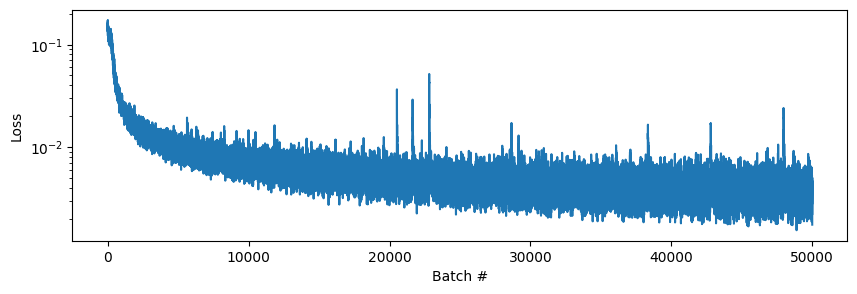

In [5]:
log = json.load(open(model_name + "_log.json",'r'))
fig,ax = plot_training_log(log=log["losses"],loss_type='position', w=1)

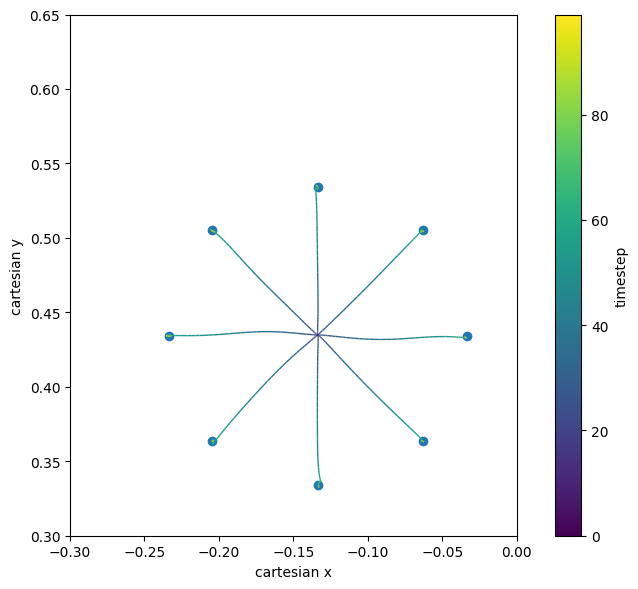

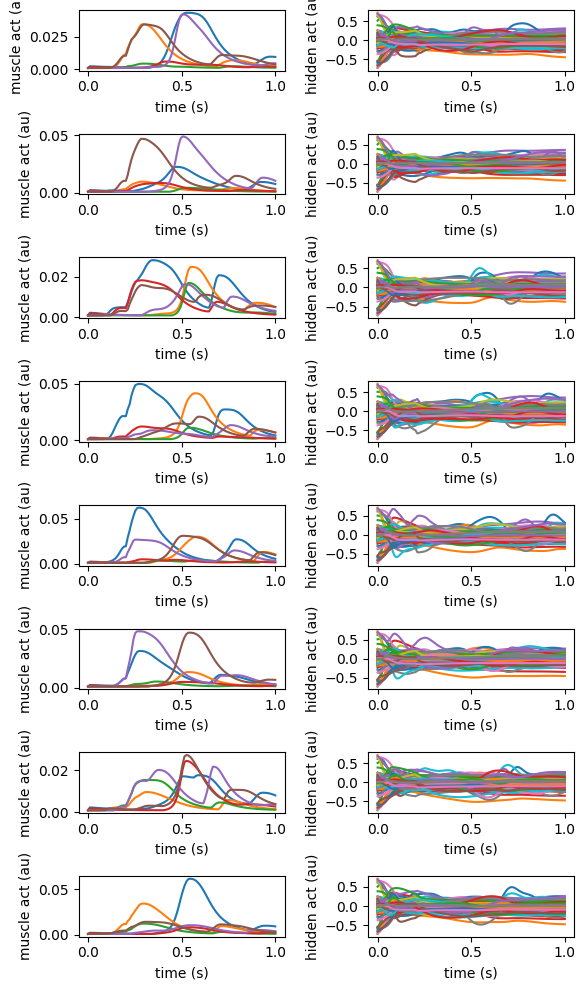

In [6]:
# TEST NETWORK ON CENTRE-OUT

data = test(model_name + "_cfg.json", model_name + "_weights")

fig, ax = plot_simulations(xy=data['xy'], target_xy=data['tg'], figsize=(8,6))
fig, ax = plot_activation(data['all_hidden'], data['all_muscle'])

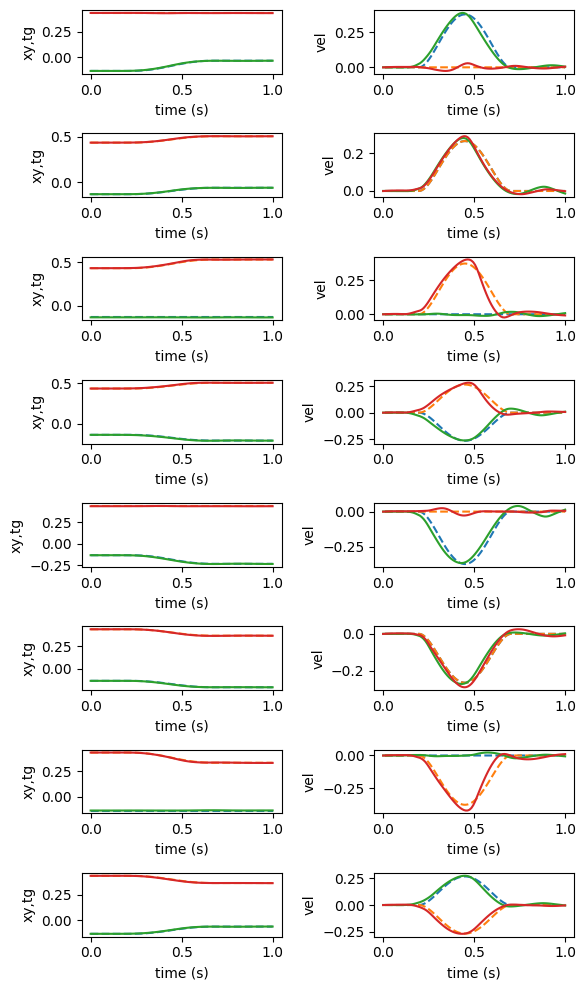

In [7]:
fig, ax = plot_kinematics(all_xy=data["xy"], all_tg=data["tg"], all_vel=data["vel"])